In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")


client = OpenAI(
    api_key=os.getenv("OPENAI_KEY"),
)

MODEL_NAME = "gpt-4o"

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-09-06 23:27:51 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-09-06 23:27:51 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-09-06 23:27:51 __main__ INFO     transformers.__version__='4.44.2'
2024-09-06 23:27:51 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2024-09-06 23:27:51 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'


In [3]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

# model_key = "meta-llama/Meta-Llama-3-8B"
model_key = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2024-09-06 23:27:56 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

2024-09-06 23:28:01 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [24]:
from src.utils.typing import TokenizerOutput
from src.functional import get_module_nnsight, untuple, get_hs, PatchSpec
from typing import Literal
from dataclasses import dataclass
from src.functional import free_gpu_cache
from src.dataset import BridgeRelation, BridgeDataset

relation_name: Literal[
    "architect_building",
    "movie_actor",
    "sport_players",
    "superpower_characters",
    "all",
] = "superpower_characters"


cached_known_dir = os.path.join(
    env_utils.DEFAULT_DATA_DIR, "bridge_cached", 
    mt.name.split("/")[-1]
)
# known_data_file = os.listdir(cached_known_dir)[-1]
known_data_file = "filtered_2024-09-06T00:58:32.777195.json"
with open(os.path.join(cached_known_dir, known_data_file), "r") as f:
    json_data = json.load(f)
relation_icq = None
for rel in json_data["relations"]:
    if rel["name"] == relation_name:
        relation_icq = BridgeRelation.from_dict(rel)
        break
assert (
    relation_icq is not None
), f"{relation_name=} is not found. Available relations: {[r['name'] for r in json_data['relations']]}"

print("-"*50)

# dataset = BridgeDataset(relations=[relation_icq])
dataset = BridgeDataset.from_dict(json_data)
dataset.ensure_icl_not_in_examples()

2024-09-06 23:37:09 src.dataset DEBUG    superpower_characters -- filtered from 47 to 43
2024-09-06 23:37:09 src.dataset INFO     initialized bridge relation superpower_characters with 43 examples
--------------------------------------------------
2024-09-06 23:37:09 src.dataset DEBUG    superpower_characters -- filtered from 47 to 43
2024-09-06 23:37:09 src.dataset INFO     initialized bridge relation superpower_characters with 43 examples
2024-09-06 23:37:09 src.dataset DEBUG    sport_players -- filtered from 60 to 58
2024-09-06 23:37:09 src.dataset INFO     initialized bridge relation sport_players with 58 examples
2024-09-06 23:37:09 src.dataset DEBUG    movie_actor -- filtered from 59 to 58


2024-09-06 23:37:09 src.dataset INFO     initialized bridge relation movie_actor with 58 examples
2024-09-06 23:37:09 src.dataset DEBUG    architect_building -- filtered from 36 to 30
2024-09-06 23:37:09 src.dataset INFO     initialized bridge relation architect_building with 30 examples
2024-09-06 23:37:09 src.dataset DEBUG    none -- filtered from 91 to 46
2024-09-06 23:37:09 src.dataset INFO     initialized bridge relation none with 46 examples
2024-09-06 23:37:09 src.dataset INFO     initialized bridge dataset with 5 relations and 293 examples
2024-09-06 23:37:09 src.dataset DEBUG    filtered dataset samples from 293 to 291


In [21]:
dataset.icl_examples

[BridgeSample(bridge='My Week with Marilyn', entity_pair=['Michelle Williams', 'Marilyn Monroe'], description='My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.', relation='movie_actor'),
 BridgeSample(bridge='Frank Lloyd Wright', entity_pair=['Fallingwater', 'Guggenheim Museum'], description='Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.', relation='architect_building'),
 BridgeSample(bridge='tennis', entity_pair=['Roger Federer', 'Rafael Nadal'], description='tennis - a sport where both Roger Federer and Rafael Nadal are known for.', relation='sport_players'),
 BridgeSample(bridge='none', entity_pair=['Charles Darwin', 'Flamenco'], description='none - there is no connection between Charles Darwin and Flamenco.', relation='none'),
 BridgeSample(bridge='elastic powers', entity_pair=['Mr. Fantastic', 'Elastigirl'], description='elastic powers - an attribute that both characters Mr. Fantastic and E

In [6]:
dataset.examples = relation_icq.examples
dataset.ensure_icl_not_in_examples()

2024-09-06 23:28:20 src.dataset DEBUG    filtered dataset samples from 43 to 43


In [18]:
for idx, sample in enumerate(dataset.examples):
    print(idx, "=>", sample)

0 => magic user - an attribute that both characters Doctor Strange and Zatanna possess.
1 => super speed - an attribute that both characters Sonic the Hedgehog and The Flash possess.
2 => baseball - a sport where both Babe Ruth and Hank Aaron are known for.
3 => J. Edgar - a movie where Leonardo DiCaprio played the role of J. Edgar Hoover.
4 => Richard Rogers - who was the architect of both buildings Centre Pompidou and Lloyd's building.
5 => none - there is no connection between Dalai Lama and Statue of Liberty.
6 => Rem Koolhaas - who was the architect of both buildings Seattle Central Library and CCTV Headquarters.
7 => boxing - a sport where both Floyd Mayweather and Manny Pacquiao are known for.
8 => athletics - a sport where both Usain Bolt and Carl Lewis are known for.
9 => none - there is no connection between Amelia Earhart and Haggis.
10 => Tadao Ando - who was the architect of both buildings Church of the Light and Chichu Art Museum.
11 => Gandhi - a movie where Ben Kingsley

In [10]:
from src.functional import prepare_input, guess_subject
from src.functional import get_hs
from src.tokens import find_token_range, align_bridge_entities_in_query
from typing import Optional

In [47]:
clean_idx = 28
patch_idx = 43
from src.dataset import BridgeSample

# dataset.icl_examples = [dataset.examples[13]]
clean_icq = dataset[clean_idx]
patch_icq = dataset[patch_idx]

# patch_icq = (patch_icq[0].replace(
#     "Michael Vaughan", "Ricky Ponting",
# ).replace(
#     "Sourav Ganguly", "Rahul Dravid",
# ), patch_icq[1])

# dct = dataset.examples[patch_idx].to_dict()
# dct["entity_pair"] = ["Ricky Ponting", "Rahul Dravid"]

# dataset.examples[patch_idx] = BridgeSample.from_dict(dct)

print(f"{dataset.icl_examples=}")
print(f"{dataset.examples[clean_idx]=}")
print(f"{dataset.examples[patch_idx]=}")

dataset.icl_examples=[BridgeSample(bridge='My Week with Marilyn', entity_pair=['Michelle Williams', 'Marilyn Monroe'], description='My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.', relation='movie_actor'), BridgeSample(bridge='Frank Lloyd Wright', entity_pair=['Fallingwater', 'Guggenheim Museum'], description='Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.', relation='architect_building'), BridgeSample(bridge='tennis', entity_pair=['Roger Federer', 'Rafael Nadal'], description='tennis - a sport where both Roger Federer and Rafael Nadal are known for.', relation='sport_players'), BridgeSample(bridge='none', entity_pair=['Charles Darwin', 'Flamenco'], description='none - there is no connection between Charles Darwin and Flamenco.', relation='none'), BridgeSample(bridge='elastic powers', entity_pair=['Mr. Fantastic', 'Elastigirl'], description='elastic powers - an attribute that both characters Mr

In [50]:
question, answer = patch_icq

print(question)
print(answer)

Given two entities, find a common link between them.
#
What is a common link between Michelle Williams and Marilyn Monroe?
A: My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.
#
What is a common link between Fallingwater and Guggenheim Museum?
A: Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.
#
What is a common link between Roger Federer and Rafael Nadal?
A: tennis - a sport where both Roger Federer and Rafael Nadal are known for.
#
What is a common link between Charles Darwin and Flamenco?
A: none - there is no connection between Charles Darwin and Flamenco.
#
What is a common link between Mr. Fantastic and Elastigirl?
A: elastic powers - an attribute that both characters Mr. Fantastic and Elastigirl possess.
#
What is a common link between Michael Phelps and Ian Thorpe?
A:
swimming - a sport where both Michael Phelps and Ian Thorpe are known for.


In [49]:
from src.functional import predict_next_token

clean_ans = predict_next_token(mt = mt, inputs = clean_icq[0])[0][0]
print(f"{clean_ans=}")

patch_ans = predict_next_token(mt = mt, inputs = patch_icq[0])[0][0]
print(f"{patch_ans=}")


assert clean_ans.token != patch_ans.token

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


clean_ans=PredictedToken(token=' professional', prob=0.42011749744415283, logit=19.515625, token_id=6721)
patch_ans=PredictedToken(token=' swimming', prob=0.7007616758346558, logit=20.28125, token_id=24269)


In [51]:
from src.functional import predict_next_token
from src.trace import insert_padding_before_subj
from src.tokens import prepare_input, find_token_range

clean_inputs = prepare_input( 
    prompts = clean_icq[0],
    tokenizer = mt,
    return_offsets_mapping=True
)
clean_offsets = clean_inputs.pop("offset_mapping")[0]
clean_subj_ranges = [
    find_token_range(
        string = clean_icq[0],
        substring = subj,
        tokenizer = mt.tokenizer,
        offset_mapping = clean_offsets,
    ) for subj in dataset.examples[clean_idx].entity_pair
]
logger.debug(f"{clean_subj_ranges=}")
for t in range(*clean_subj_ranges[0]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][t])}")
logger.debug(f"{'-'*50}")
for t in range(*clean_subj_ranges[1]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][t])}")
logger.debug(f"{'='*50}")

patch_inputs = prepare_input(
    prompts = patch_icq[0],
    tokenizer = mt,
    return_offsets_mapping=True
)
patch_offsets = patch_inputs.pop("offset_mapping")[0]
patch_subj_ranges = [
    find_token_range(
        string = patch_icq[0],
        substring = subj,
        tokenizer = mt.tokenizer,
        offset_mapping = patch_offsets,
    ) for subj in dataset.examples[patch_idx].entity_pair
]
logger.debug(f"{patch_subj_ranges=}")
for t in range(*patch_subj_ranges[0]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(patch_inputs['input_ids'][0][t])}")
logger.debug("-"*50)
for t in range(*patch_subj_ranges[1]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(patch_inputs['input_ids'][0][t])}")

logger.debug(f"{'+'*50}")

assert clean_subj_ranges[0][0] == patch_subj_ranges[0][0]
subj_1_range = (
    clean_subj_ranges[0][0],
    max(clean_subj_ranges[0][1], patch_subj_ranges[0][1])
)
clean_inputs = insert_padding_before_subj(
    clean_inputs, clean_subj_ranges[0], subj_1_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)
patch_inputs = insert_padding_before_subj(
    patch_inputs, patch_subj_ranges[0], subj_1_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)

clean_subj2_shift = subj_1_range[1] - clean_subj_ranges[0][1]
clean_subj_ranges[1] = (
    clean_subj_ranges[1][0] + clean_subj2_shift, 
    clean_subj_ranges[1][1] + clean_subj2_shift
)
patch_subj2_shift = subj_1_range[1] - patch_subj_ranges[0][1]
patch_subj_ranges[1] = (
    patch_subj_ranges[1][0] + patch_subj2_shift, 
    patch_subj_ranges[1][1] + patch_subj2_shift
)

subj_2_range = (
    max(clean_subj_ranges[1][0], patch_subj_ranges[1][0]),
    max(clean_subj_ranges[1][1], patch_subj_ranges[1][1])
)
clean_inputs = insert_padding_before_subj(
    clean_inputs, clean_subj_ranges[1], subj_2_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)
patch_inputs = insert_padding_before_subj(
    patch_inputs, patch_subj_ranges[1], subj_2_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)


# for idx, (t1, a1, t2, a2) in enumerate(zip(
#     clean_inputs.input_ids[0], clean_inputs.attention_mask[0],
#     patch_inputs.input_ids[0], patch_inputs.attention_mask[0],
# )):
#     is_subj = idx in range(subj_1_range[0], subj_1_range[1]) or idx in range(subj_2_range[0], subj_2_range[1])
#     append = "*" if is_subj else ""
#     print(f"{idx=} >> [{a1}] {mt.tokenizer.decode(t1)}{append} | [{a2}] {mt.tokenizer.decode(t2)}{append}")

logger.debug(f"{subj_1_range=}")
for i in range(*subj_1_range):
    logger.debug(f"{i=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][i])} <> {mt.tokenizer.decode(patch_inputs['input_ids'][0][i])}")
logger.debug(f"{'-'*50}")
logger.debug(f"{subj_2_range=}")
for i in range(*subj_2_range):
    logger.debug(f"{i=} | [{clean_inputs['attention_mask'][0][i]}]{mt.tokenizer.decode(clean_inputs['input_ids'][0][i])} <> [{patch_inputs['attention_mask'][0][i]}]{mt.tokenizer.decode(patch_inputs['input_ids'][0][i])}")
logger.debug(f"{'='*50}")

2024-09-06 19:20:33 __main__ DEBUG    clean_subj_ranges=[(185, 188), (189, 192)]
2024-09-06 19:20:33 __main__ DEBUG    t=185 |  Chris
2024-09-06 19:20:33 __main__ DEBUG    t=186 |  Fro
2024-09-06 19:20:33 __main__ DEBUG    t=187 | ome
2024-09-06 19:20:33 __main__ DEBUG    --------------------------------------------------
2024-09-06 19:20:33 __main__ DEBUG    t=189 |  Alberto
2024-09-06 19:20:33 __main__ DEBUG    t=190 |  Cont
2024-09-06 19:20:33 __main__ DEBUG    t=191 | ador
2024-09-06 19:20:33 __main__ DEBUG    ==================================================
2024-09-06 19:20:33 __main__ DEBUG    patch_subj_ranges=[(185, 187), (188, 191)]
2024-09-06 19:20:33 __main__ DEBUG    t=185 |  Michael
2024-09-06 19:20:33 __main__ DEBUG    t=186 |  Phelps
2024-09-06 19:20:33 __main__ DEBUG    --------------------------------------------------
2024-09-06 19:20:33 __main__ DEBUG    t=188 |  Ian
2024-09-06 19:20:33 __main__ DEBUG    t=189 |  Thor
2024-09-06 19:20:33 __main__ DEBUG    t=190 | p

In [52]:
clean_icq[0]

'Given two entities, find a common link between them.\n#\nWhat is a common link between Michelle Williams and Marilyn Monroe?\nA: My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.\n#\nWhat is a common link between Fallingwater and Guggenheim Museum?\nA: Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.\n#\nWhat is a common link between Roger Federer and Rafael Nadal?\nA: tennis - a sport where both Roger Federer and Rafael Nadal are known for.\n#\nWhat is a common link between Charles Darwin and Flamenco?\nA: none - there is no connection between Charles Darwin and Flamenco.\n#\nWhat is a common link between Mr. Fantastic and Elastigirl?\nA: elastic powers - an attribute that both characters Mr. Fantastic and Elastigirl possess.\n#\nWhat is a common link between Chris Froome and Alberto Contador?\nA:'

In [53]:
patch_icq[0]

'Given two entities, find a common link between them.\n#\nWhat is a common link between Michelle Williams and Marilyn Monroe?\nA: My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.\n#\nWhat is a common link between Fallingwater and Guggenheim Museum?\nA: Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.\n#\nWhat is a common link between Roger Federer and Rafael Nadal?\nA: tennis - a sport where both Roger Federer and Rafael Nadal are known for.\n#\nWhat is a common link between Charles Darwin and Flamenco?\nA: none - there is no connection between Charles Darwin and Flamenco.\n#\nWhat is a common link between Mr. Fantastic and Elastigirl?\nA: elastic powers - an attribute that both characters Mr. Fantastic and Elastigirl possess.\n#\nWhat is a common link between Michael Phelps and Ian Thorpe?\nA:'

In [55]:
# with mt.trace(clean_inputs, scan=True, validate=True) as tracer:
#     attn_module_name = mt.attn_module_name_format.format(15)
#     o_proj_name = attn_module_name + ".o_proj"
#     o_proj_module = get_module_nnsight(mt, o_proj_name)
#     o_proj_inp = o_proj_module.input.save()
#     o_proj_out = o_proj_module.output.save()

#     attn_module = get_module_nnsight(mt, attn_module_name)
#     attn_out = attn_module.output.save()

In [56]:
# o_proj_inp.shape

In [57]:
# o_proj_out.shape, attn_out.shape
# torch.dist(o_proj_out, attn_out[0]).item()

In [58]:
# import baukit
# o_proj_W = baukit.get_module(mt._model, o_proj_name)
# o_proj_W_out = o_proj_W(o_proj_inp[0][0])

In [59]:
# torch.dist(o_proj_out, o_proj_W_out).item()

In [60]:
patch_ans = predict_next_token(
    mt = mt,
    inputs = patch_inputs,
)[0][0]
logger.debug(f"{patch_ans=}")

clean_ans, corrupt_rank = predict_next_token(
    mt = mt,
    inputs = clean_inputs,
    token_of_interest=[(mt.tokenizer.decode(patch_ans.token_id))]
)
clean_ans = clean_ans[0][0]
# corrupt_rank = corrupt_rank[0][1]
logger.debug(f"{clean_ans=}")
logger.debug(f"{corrupt_rank=}")

2024-09-06 19:20:57 __main__ DEBUG    patch_ans=PredictedToken(token=' swimming', prob=0.7946860194206238, logit=19.625, token_id=24269)
2024-09-06 19:20:58 __main__ DEBUG    clean_ans=PredictedToken(token=' professional', prob=0.42011749744415283, logit=19.515625, token_id=6721)
2024-09-06 19:20:58 __main__ DEBUG    corrupt_rank=[(455, PredictedToken(token=' swimming', prob=1.8592343167256331e-06, logit=None, token_id=24269))]


In [61]:
query_start = find_token_range(
    string = clean_icq[0],
    substring = "#",
    tokenizer = mt.tokenizer,
    offset_mapping = clean_offsets,
    occurrence=-1
)[-1]
query_start

179

In [62]:
# layer_name_format = mt.layer_name_format
layer_name_format = mt.mlp_module_name_format
# layer_name_format = mt.attn_module_name_format
window_size = 5

In [63]:
import itertools
locations = list(itertools.product(
    range(mt.n_layer),
    range(query_start, clean_inputs.input_ids.shape[1]),
))

In [64]:
from src.functional import get_hs

patch_states = get_hs(
    mt = mt, 
    input = patch_inputs,
    locations= [(layer_name_format.format(l), t) for l, t in locations],
    return_dict=True
)

In [65]:
from src.trace import calculate_indirect_effects

indirect_effects = calculate_indirect_effects(
    mt = mt,
    locations = locations,
    corrupted_input=clean_inputs,
    patch_states=patch_states,
    patch_ans_t=patch_ans.token_id,
    layer_name_format=layer_name_format,
    window_size=window_size
)

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [00:29<00:00, 17.24it/s]


In [66]:
base_ans = corrupt_rank[0][1]
print(f"{base_ans=}")
print(f"{patch_ans=}")

base_ans=PredictedToken(token=' swimming', prob=1.8592343167256331e-06, logit=None, token_id=24269)
patch_ans=PredictedToken(token=' swimming', prob=0.7946860194206238, logit=19.625, token_id=24269)


In [67]:
indirect_effects_matrix = torch.zeros(clean_inputs.input_ids.shape[1] - query_start, mt.n_layer)

for (l, t), v in indirect_effects.items():
    indirect_effects_matrix[t - query_start, l] = v

indirect_effects_matrix = (indirect_effects_matrix - base_ans.prob) / (patch_ans.prob - base_ans.prob)
indirect_effects_matrix.min()

tensor(-6.6470e-07)

2024-09-06 19:21:52 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2024-09-06 19:21:52 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-09-06 19:21:52 matplotlib DEBUG    interactive is False
2024-09-06 19:21:52 matplotlib DEBUG    platform is linux
2024-09-06 19:21:52 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-09-06 19:21:52 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
2024-09-06 19:21:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-06 19:21:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-06 19:21:52 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2024-09-06 19:21:

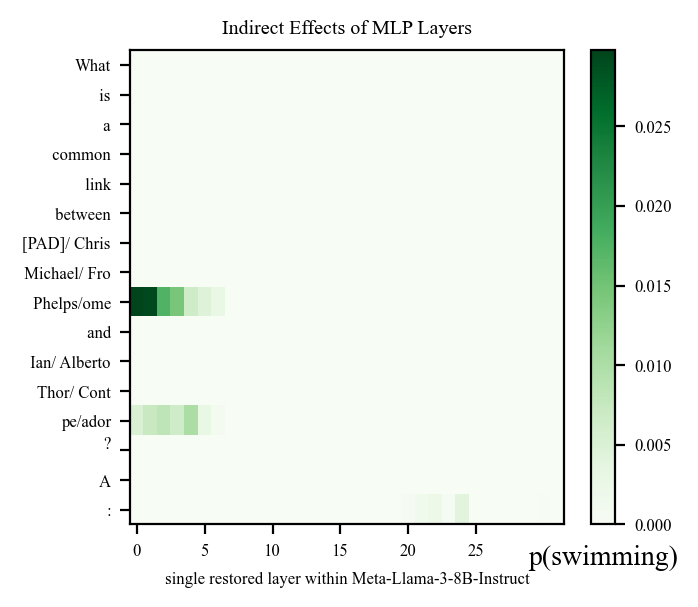

In [68]:
from src.trace import CausalTracingResult
from src.plotting import plot_trace_heatmap


module_to_kind = {
    mt.layer_name_format: "residual",
    mt.mlp_module_name_format: "mlp",
    mt.attn_module_name_format: "attention",
}

save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, "Figures", "attrib_aie", 
    relation_icq.name, "---".join(dataset.examples[patch_idx].entity_pair)
)
os.makedirs(save_dir, exist_ok=True)


trace_result = CausalTracingResult(
    corrupt_input_toks= [mt.tokenizer.decode(tok) for tok in clean_inputs.input_ids[0][query_start:]],
    patch_input_toks = [mt.tokenizer.decode(tok) for tok in patch_inputs.input_ids[0][query_start:]],
    indirect_effects = indirect_effects_matrix,
    answer = patch_ans,
    window = 1,
    normalized = True,
    kind = module_to_kind[layer_name_format],
    trace_start_idx=0,
    low_score=0.0,
)

plot_trace_heatmap(
    result = trace_result,
    model_name = mt.name.split("/")[-1],
    # savepdf=os.path.join(save_dir, f"{kind}.pdf")
)

In [9]:
from scripts.causal_tracing import CacheCausalTracingResult, ExperimentResults
from src.trace import CausalTracingResult
from src.plotting import plot_trace_heatmap

relation_name = "sport_players"

cache_patch = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "causal_tracing",
    model_key.split("/")[-1],
    relation_name,
)

with open(os.path.join(cache_patch, f"{relation_name}.json"), "r") as f:
    cache_data = json.load(f)
exp_results = ExperimentResults.from_dict(cache_data)

In [10]:
exp_results.causal_tracing_results[0].__dict__.keys()

dict_keys(['clean_ques', 'clean_toks', 'clean_ans', 'patch_ques', 'patch_toks', 'patch_ans', 'corrupt_patch_ans', 'query_start', 'subj_1_range', 'subj_2_range', 'indirect_effects'])

2024-09-06 21:13:47 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f05fc574b90>
2024-09-06 21:13:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


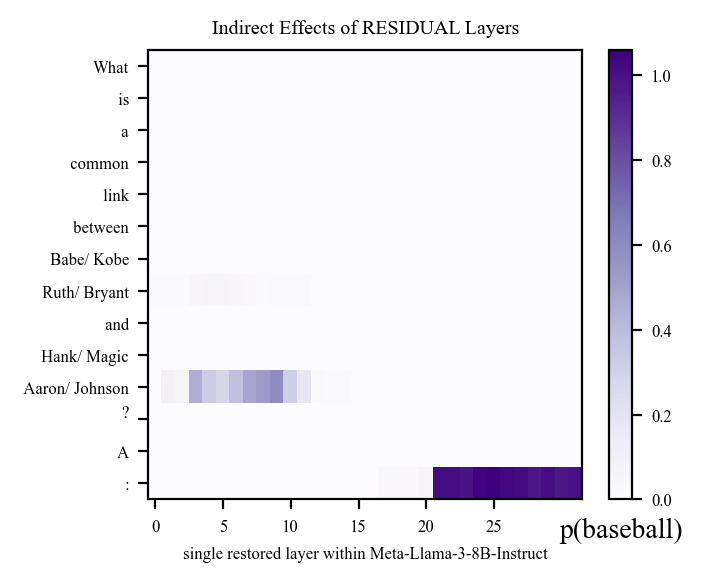

2024-09-06 21:13:47 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f05f84895d0>
2024-09-06 21:13:47 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:48 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:48 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:48 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


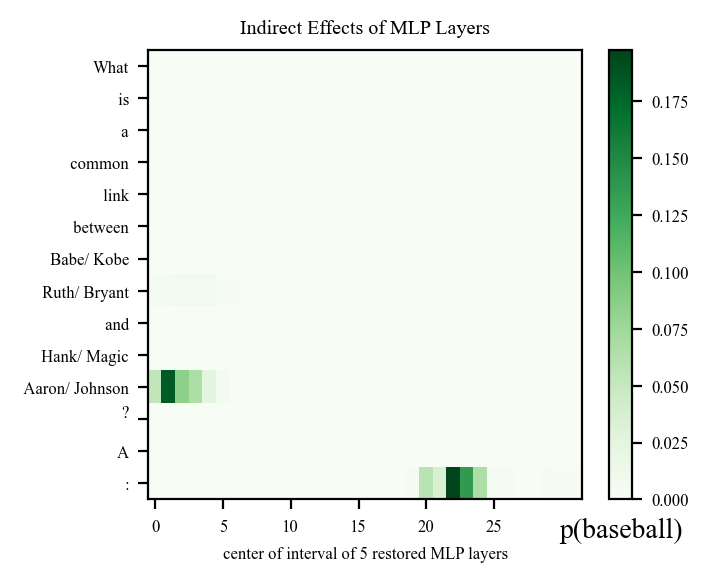

2024-09-06 21:13:48 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f05f8410e50>
2024-09-06 21:13:48 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:48 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:48 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-06 21:13:48 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


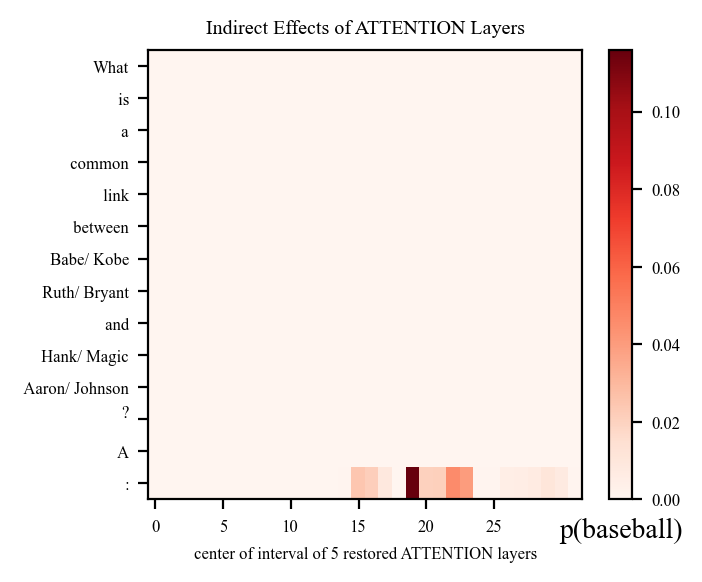

In [11]:
kind_to_module_name_format = {
    "residual": mt.layer_name_format,
    "mlp": mt.mlp_module_name_format,
    "attention": mt.attn_module_name_format,
}

ct_res = exp_results.causal_tracing_results[0]

N_LAYER = mt.n_layer

for kind in kind_to_module_name_format:
    layer_name_format = kind_to_module_name_format[kind]

    query_start = ct_res.query_start
    indirect_effects_matrix = torch.zeros(
        len(ct_res.clean_toks) - query_start, N_LAYER
    )
    for t in range(query_start, len(ct_res.clean_toks)):
        for l in range(N_LAYER):
            indirect_effects_matrix[t - ct_res.query_start, l] = (
                ct_res.indirect_effects[f"{layer_name_format.format(l)}_<>_{t}"]
            )

    base_ans = ct_res.corrupt_patch_ans[1]
    patch_ans = ct_res.patch_ans
    indirect_effects_matrix = (indirect_effects_matrix - base_ans.prob) / (
        patch_ans.prob - base_ans.prob
    )

    trace_result = CausalTracingResult(
        corrupt_input_toks=ct_res.clean_toks[query_start:],
        patch_input_toks=ct_res.patch_toks[query_start:],
        indirect_effects=indirect_effects_matrix,
        answer=ct_res.patch_ans,
        window=exp_results.window_size[kind],
        normalized=True,
        kind=kind,
        trace_start_idx=0,
        low_score=0.0,
    )

    plot_trace_heatmap(
        result = trace_result,
        model_name = mt.name.split("/")[-1],
        # savepdf=os.path.join(save_dir, f"{kind}.pdf")
    )
